In [36]:
import os
import datetime
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch import optim
from torchsummary import summary

In [37]:
## File input/output related attributes
## Hint: you might need to modify these variables for supporting your os system
training_dataroot = "train.csv"                 # Training data file name
testing_dataroot = "test.csv"                   # Testing data file name
model_save_root = "./model"                     # Root directory name for saving your models
test_prediction_csv_output_path = "Lab4.csv"    # Testing prediction csv file name

# create the model saving root if not exists
# Hint: if you encountering issues like os error, you can comment the following 2 lines of code and create the folder for saving your model manually
if not os.path.exists(model_save_root):
    os.makedirs(model_save_root)


## Model training related attributes
## TODO: try to modify the hyperparameters for better model performance
use_gpu = True       # whether use GPU when training model (*note that it will be ignored if there's no supported GPU in your machine and use CPU instead)
BATCH_SIZE = 32       # number of batch size when training model
NUM_EPOCHS = 240      # number of epochs when training model
LEARNING_RATE = 0.0003  # learning rate of the optimizer

In [38]:
df_train_origin = pd.read_csv(training_dataroot)
df_test = pd.read_csv(testing_dataroot)

display(df_train_origin.head(5))
display(df_test.head(5))

print("Number of training data: {}".format(len(df_train_origin)))
print("Number of testing data:  {}".format(len(df_test)))

,battery_power,n_cores,ram,clock_speed,internal_memory,bluetooh,wifi,touch_screen,front_camera_resolution,primary_camera_resolution,...,mobile_width,screen_height,screen_width,screen_resolution_height,screen_resolution_width,four_g,five_g,dual_sim,talk_time,price_level
0,1549,5,3836,0.7,8,0,0,1,4,7,...,158,12,7,721,1514,1,0,0,15,2
1,525,7,1609,2.5,12,0,0,0,5,20,...,159,16,11,82,670,0,0,0,3,0
2,930,1,1743,2.1,54,0,0,1,0,13,...,80,7,1,1569,1763,0,0,1,9,2
3,852,5,315,1.8,8,0,0,0,5,9,...,160,7,6,683,1349,1,1,1,20,0
4,1221,7,2638,2.3,35,0,1,1,7,19,...,152,19,16,765,1899,1,1,0,14,2


,battery_power,n_cores,ram,clock_speed,internal_memory,bluetooh,wifi,touch_screen,front_camera_resolution,primary_camera_resolution,mobile_depth,mobile_width,screen_height,screen_width,screen_resolution_height,screen_resolution_width,four_g,five_g,dual_sim,talk_time
0,772,3,929,2.1,6,1,1,1,7,10,0.1,100,13,6,1277,1207,0,0,1,5
1,1097,8,3269,0.5,64,0,1,0,6,8,0.2,161,14,3,419,843,1,0,1,9
2,1470,7,1633,2.2,33,0,0,0,4,10,0.4,138,18,4,1790,1988,1,1,1,4
3,1163,5,1568,1.9,2,1,0,0,6,20,0.9,133,14,0,919,1076,1,0,0,19
4,1285,7,2094,2.4,57,0,0,0,8,2,1.0,140,8,9,212,500,1,0,0,11


Number of training data: 1700
Number of testing data:  300


In [39]:
# Split df_train_origin into training set (df_train) and validation set (df_valid)
## TODO: 
df_train, df_valid = train_test_split(df_train_origin, test_size=0.2, random_state=0)  # set random_state=0

In [40]:
# reset index of df_train and df_valid
df_train = df_train.reset_index(drop=True)
df_valid = df_valid.reset_index(drop=True)

In [41]:
# show df_train, df_valid, df_test
display(df_train.head(5))
display(df_valid.head(5))
display(df_test.head(5))

print("Feature Names = {}".format([c for c in df_train.columns.values if c in df_test.columns.values]))
print("Label Name = {}".format([c for c in df_train.columns.values if c not in df_test.columns.values]))
print()
print("(Number of cases, Number of features) -> ")
print("Train: {}".format(df_train.shape))
print("Valid: {}".format(df_valid.shape))
print("Test:  {}".format(df_test.shape))

,battery_power,n_cores,ram,clock_speed,internal_memory,bluetooh,wifi,touch_screen,front_camera_resolution,primary_camera_resolution,...,mobile_width,screen_height,screen_width,screen_resolution_height,screen_resolution_width,four_g,five_g,dual_sim,talk_time,price_level
0,761,7,2248,0.5,3,1,1,1,9,15,...,196,19,3,1325,1945,1,0,0,15,2
1,1049,6,433,0.6,2,0,0,0,8,10,...,172,10,7,39,1564,1,1,1,6,0
2,1880,4,2968,0.5,7,0,0,1,0,1,...,104,9,0,890,1019,1,1,0,3,3
3,1481,3,2635,1.1,18,1,1,0,0,0,...,134,17,16,249,522,1,0,0,4,2
4,643,6,1417,0.7,23,1,0,0,3,13,...,156,13,6,314,1400,1,1,1,2,1


,battery_power,n_cores,ram,clock_speed,internal_memory,bluetooh,wifi,touch_screen,front_camera_resolution,primary_camera_resolution,...,mobile_width,screen_height,screen_width,screen_resolution_height,screen_resolution_width,four_g,five_g,dual_sim,talk_time,price_level
0,1602,3,1824,2.4,38,1,1,1,4,20,...,145,14,7,466,788,1,1,1,20,0
1,989,3,2349,0.7,51,1,1,0,13,15,...,132,10,1,670,804,1,1,0,20,1
2,1323,4,1892,2.5,28,1,1,1,10,12,...,131,10,0,162,619,1,1,1,15,1
3,947,2,2842,0.8,22,0,0,0,0,13,...,197,16,12,1176,1220,1,1,1,2,2
4,1541,4,1241,1.5,4,1,1,1,1,10,...,109,7,1,966,1656,1,1,1,4,1


,battery_power,n_cores,ram,clock_speed,internal_memory,bluetooh,wifi,touch_screen,front_camera_resolution,primary_camera_resolution,mobile_depth,mobile_width,screen_height,screen_width,screen_resolution_height,screen_resolution_width,four_g,five_g,dual_sim,talk_time
0,772,3,929,2.1,6,1,1,1,7,10,0.1,100,13,6,1277,1207,0,0,1,5
1,1097,8,3269,0.5,64,0,1,0,6,8,0.2,161,14,3,419,843,1,0,1,9
2,1470,7,1633,2.2,33,0,0,0,4,10,0.4,138,18,4,1790,1988,1,1,1,4
3,1163,5,1568,1.9,2,1,0,0,6,20,0.9,133,14,0,919,1076,1,0,0,19
4,1285,7,2094,2.4,57,0,0,0,8,2,1.0,140,8,9,212,500,1,0,0,11


Feature Names = ['battery_power', 'n_cores', 'ram', 'clock_speed', 'internal_memory', 'bluetooh', 'wifi', 'touch_screen', 'front_camera_resolution', 'primary_camera_resolution', 'mobile_depth', 'mobile_width', 'screen_height', 'screen_width', 'screen_resolution_height', 'screen_resolution_width', 'four_g', 'five_g', 'dual_sim', 'talk_time']
Label Name = ['price_level']

(Number of cases, Number of features) -> 
Train: (1360, 21)
Valid: (340, 21)
Test:  (300, 20)


In [42]:
# names of numerical features
numerical_feature_column_names = [
    "battery_power", 
    "n_cores", 
    "ram", 
    "clock_speed", 
    "internal_memory", 
    "front_camera_resolution", 
    "primary_camera_resolution", 
    "mobile_depth", 
    "mobile_width", 
    "screen_height", 
    "screen_width", 
    "screen_resolution_height", 
    "screen_resolution_width", 
    "talk_time", 
]

# show numerical features before preprocessing
numerical_train = df_train[numerical_feature_column_names]
numerical_valid = df_valid[numerical_feature_column_names]
numerical_test = df_test[numerical_feature_column_names]
print(
    "Before min-max scaling: \n" \
    "min = {} \n" \
    "max = {} \n".format(
        np.min(numerical_train.values, axis=0), np.max(numerical_train.values, axis=0), 
    )
)

# create scaler and preprocess numerical features with it
## TODO: 
min_max_scaler = MinMaxScaler()
scaled_train = min_max_scaler.fit_transform(numerical_train)
scaled_valid = min_max_scaler.transform(numerical_valid)
scaled_test = min_max_scaler.transform(numerical_test)
print(
    "After min-max scaling: \n" \
    "min = {} \n" \
    "max = {} \n".format(
        np.min(scaled_train, axis=0), np.max(scaled_train, axis=0), 
    )
)

Before min-max scaling: 
min = [5.01e+02 1.00e+00 2.56e+02 5.00e-01 2.00e+00 0.00e+00 0.00e+00 1.00e-01
 8.00e+01 5.00e+00 0.00e+00 0.00e+00 5.00e+02 2.00e+00] 
max = [1.997e+03 8.000e+00 3.998e+03 3.000e+00 6.400e+01 1.900e+01 2.000e+01
 1.000e+00 2.000e+02 1.900e+01 1.800e+01 1.949e+03 1.998e+03 2.000e+01] 

After min-max scaling: 
min = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 
max = [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.] 



In [43]:
# create new dataframe with processed numerical features: scaled_train, scaled_valid, scaled_test
df_scaled_train = pd.DataFrame(
    data=scaled_train, 
    columns=min_max_scaler.get_feature_names_out(), 
)
df_scaled_valid = pd.DataFrame(
    data=scaled_valid, 
    columns=min_max_scaler.get_feature_names_out(), 
)
df_scaled_test = pd.DataFrame(
    data=scaled_test, 
    columns=min_max_scaler.get_feature_names_out(), 
)

In [44]:
# show df_scaled_train, df_scaled_valid, df_scaled_test
display(df_scaled_train.head(5))
display(df_scaled_valid.head(5))
display(df_scaled_test.head(5))

print("Numerical Feature Names = {}".format(df_scaled_train.columns.values))
print()
print("(Number of cases, Number of features) -> ")
print("Train: {}".format(df_scaled_train.shape))
print("Valid: {}".format(df_scaled_valid.shape))
print("Test:  {}".format(df_scaled_test.shape))

,battery_power,n_cores,ram,clock_speed,internal_memory,front_camera_resolution,primary_camera_resolution,mobile_depth,mobile_width,screen_height,screen_width,screen_resolution_height,screen_resolution_width,talk_time
0,0.173797,0.857143,0.532336,0.00,0.016129,0.473684,0.75,0.777778,0.966667,1.000000,0.166667,0.679836,0.964619,0.722222
1,0.366310,0.714286,0.047301,0.04,0.000000,0.421053,0.50,0.222222,0.766667,0.357143,0.388889,0.020010,0.710280,0.222222
2,0.921791,0.428571,0.724746,0.00,0.080645,0.000000,0.05,0.555556,0.200000,0.285714,0.000000,0.456644,0.346462,0.055556
3,0.655080,0.285714,0.635756,0.24,0.258065,0.000000,0.00,0.444444,0.450000,0.857143,0.888889,0.127758,0.014686,0.111111
4,0.094920,0.714286,0.310262,0.08,0.338710,0.157895,0.65,0.666667,0.633333,0.571429,0.333333,0.161108,0.600801,0.000000


,battery_power,n_cores,ram,clock_speed,internal_memory,front_camera_resolution,primary_camera_resolution,mobile_depth,mobile_width,screen_height,screen_width,screen_resolution_height,screen_resolution_width,talk_time
0,0.735963,0.285714,0.419027,0.76,0.580645,0.210526,1.00,0.666667,0.541667,0.642857,0.388889,0.239097,0.192256,1.000000
1,0.326203,0.285714,0.559327,0.08,0.790323,0.684211,0.75,0.333333,0.433333,0.357143,0.055556,0.343766,0.202937,1.000000
2,0.549465,0.428571,0.437199,0.80,0.419355,0.526316,0.60,0.111111,0.425000,0.357143,0.000000,0.083120,0.079439,0.722222
3,0.298128,0.142857,0.691074,0.12,0.322581,0.000000,0.65,0.000000,0.975000,0.785714,0.666667,0.603386,0.480641,0.000000
4,0.695187,0.428571,0.263228,0.40,0.032258,0.052632,0.50,0.444444,0.241667,0.142857,0.055556,0.495639,0.771696,0.111111


,battery_power,n_cores,ram,clock_speed,internal_memory,front_camera_resolution,primary_camera_resolution,mobile_depth,mobile_width,screen_height,screen_width,screen_resolution_height,screen_resolution_width,talk_time
0,0.181150,0.285714,0.179850,0.64,0.064516,0.368421,0.5,0.000000,0.166667,0.571429,0.333333,0.655208,0.471963,0.166667
1,0.398396,1.000000,0.805184,0.00,1.000000,0.315789,0.4,0.111111,0.675000,0.642857,0.166667,0.214982,0.228972,0.388889
2,0.647727,0.857143,0.367985,0.68,0.500000,0.210526,0.5,0.333333,0.483333,0.928571,0.222222,0.918420,0.993324,0.111111
3,0.442513,0.571429,0.350615,0.56,0.000000,0.315789,1.0,0.888889,0.441667,0.642857,0.000000,0.471524,0.384513,0.944444
4,0.524064,0.857143,0.491181,0.76,0.887097,0.421053,0.1,1.000000,0.500000,0.214286,0.500000,0.108774,0.000000,0.500000


Numerical Feature Names = ['battery_power' 'n_cores' 'ram' 'clock_speed' 'internal_memory'
 'front_camera_resolution' 'primary_camera_resolution' 'mobile_depth'
 'mobile_width' 'screen_height' 'screen_width' 'screen_resolution_height'
 'screen_resolution_width' 'talk_time']

(Number of cases, Number of features) -> 
Train: (1360, 14)
Valid: (340, 14)
Test:  (300, 14)


In [45]:
# names of categorical features
categorical_feature_column_names = [
    "bluetooh", 
    "wifi", 
    "touch_screen", 
    "four_g", 
    "five_g", 
    "dual_sim", 
]

# show categorical features before preprocessing
categorical_train = df_train[categorical_feature_column_names]
categorical_valid = df_valid[categorical_feature_column_names]
categorical_test = df_test[categorical_feature_column_names]
print(
    "Before one-hot encoding: \n" \
    "feature names = {} \n".format(
        categorical_train.columns.values, 
    )
)

# create encoder and preprocess categorical features with it
## TODO: 
one_hot_encoder = OneHotEncoder(handle_unknown='ignore')
one_hot_train = one_hot_encoder.fit_transform(categorical_train)
one_hot_valid = one_hot_encoder.transform(categorical_valid)
one_hot_test = one_hot_encoder.transform(categorical_test)
print(
    "After one-hot encoding: \n" \
    "feature names = {} \n".format(
        one_hot_encoder.get_feature_names_out(), 
    )
)

Before one-hot encoding: 
feature names = ['bluetooh' 'wifi' 'touch_screen' 'four_g' 'five_g' 'dual_sim'] 

After one-hot encoding: 
feature names = ['bluetooh_0' 'bluetooh_1' 'wifi_0' 'wifi_1' 'touch_screen_0'
 'touch_screen_1' 'four_g_0' 'four_g_1' 'five_g_0' 'five_g_1' 'dual_sim_0'
 'dual_sim_1'] 



In [46]:
# create new dataframe with processed categorical features: one_hot_train, one_hot_valid, one_hot_test
df_one_hot_train = pd.DataFrame(
    data=one_hot_train.toarray(), 
    columns=one_hot_encoder.get_feature_names_out(), 
)
df_one_hot_valid = pd.DataFrame(
    data=one_hot_valid.toarray(), 
    columns=one_hot_encoder.get_feature_names_out(), 
)
df_one_hot_test = pd.DataFrame(
    data=one_hot_test.toarray(), 
    columns=one_hot_encoder.get_feature_names_out(), 
)

In [47]:
# show df_one_hot_train, df_one_hot_valid, df_one_hot_test
display(df_one_hot_train.head(5))
display(df_one_hot_valid.head(5))
display(df_one_hot_test.head(5))

print("Catecorical Feature Names = {}".format(df_one_hot_train.columns.values))
print()
print("(Number of cases, Number of features) -> ")
print("Train: {}".format(df_one_hot_train.shape))
print("Valid: {}".format(df_one_hot_valid.shape))
print("Test:  {}".format(df_one_hot_test.shape))

,bluetooh_0,bluetooh_1,wifi_0,wifi_1,touch_screen_0,touch_screen_1,four_g_0,four_g_1,five_g_0,five_g_1,dual_sim_0,dual_sim_1
0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
1,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
2,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
3,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
4,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0


,bluetooh_0,bluetooh_1,wifi_0,wifi_1,touch_screen_0,touch_screen_1,four_g_0,four_g_1,five_g_0,five_g_1,dual_sim_0,dual_sim_1
0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
1,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
2,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
3,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
4,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0


,bluetooh_0,bluetooh_1,wifi_0,wifi_1,touch_screen_0,touch_screen_1,four_g_0,four_g_1,five_g_0,five_g_1,dual_sim_0,dual_sim_1
0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
1,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
2,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
3,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
4,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0


Catecorical Feature Names = ['bluetooh_0' 'bluetooh_1' 'wifi_0' 'wifi_1' 'touch_screen_0'
 'touch_screen_1' 'four_g_0' 'four_g_1' 'five_g_0' 'five_g_1' 'dual_sim_0'
 'dual_sim_1']

(Number of cases, Number of features) -> 
Train: (1360, 12)
Valid: (340, 12)
Test:  (300, 12)


In [48]:
# name of label feature
label_column_name = [
    "price_level", 
]

# extract the labels of all subjects
## TODO: 
df_label_train = df_train[label_column_name]
df_label_valid = df_valid[label_column_name]

# show number of classes and the valid values of the label
class_idxs = np.unique(df_label_train[label_column_name].values)
num_classes = len(class_idxs)
print("class_idxs = {}".format(class_idxs))
print("num classes = {}".format(num_classes))

class_idxs = [0 1 2 3]
num classes = 4


In [49]:
# show df_label_train, df_label_valid
display(df_label_train.head(5))
display(df_label_valid.head(5))

print("Label Names = {}".format(df_label_train.columns.values))
print()
print("(Number of cases, Number of features) -> ")
print("Train: {}".format(df_label_train.shape))
print("Valid: {}".format(df_label_valid.shape))

,price_level
0,2
1,0
2,3
3,2
4,1


,price_level
0,0
1,1
2,1
3,2
4,1


Label Names = ['price_level']

(Number of cases, Number of features) -> 
Train: (1360, 1)
Valid: (340, 1)


In [50]:
# concatenate dataframes of processed numerical features, processed categorical features and extracted label
df_preprocess_train = pd.concat(
    [df_scaled_train, df_one_hot_train, df_label_train], 
    axis=1, 
)
df_preprocess_valid = pd.concat(
    [df_scaled_valid, df_one_hot_valid, df_label_valid], 
    axis=1, 
)
df_preprocess_test = pd.concat(
    [df_scaled_test, df_one_hot_test], 
    axis=1, 
)

In [51]:
# show df_preprocess_train, df_preprocess_valid, df_preprocess_test
display(df_preprocess_train.head(5))
display(df_preprocess_valid.head(5))
display(df_preprocess_test.head(5))

print("Feature Names = {}".format([c for c in df_preprocess_train.columns.values if c in df_preprocess_test.columns.values]))
print("Label Name = {}".format([c for c in df_preprocess_train.columns.values if c not in df_preprocess_test.columns.values]))
print()
print("(Number of cases, Number of features) -> ")
print("Train: {}".format(df_preprocess_train.shape))
print("Valid: {}".format(df_preprocess_valid.shape))
print("Test:  {}".format(df_preprocess_test.shape))

,battery_power,n_cores,ram,clock_speed,internal_memory,front_camera_resolution,primary_camera_resolution,mobile_depth,mobile_width,screen_height,...,wifi_1,touch_screen_0,touch_screen_1,four_g_0,four_g_1,five_g_0,five_g_1,dual_sim_0,dual_sim_1,price_level
0,0.173797,0.857143,0.532336,0.00,0.016129,0.473684,0.75,0.777778,0.966667,1.000000,...,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,2
1,0.366310,0.714286,0.047301,0.04,0.000000,0.421053,0.50,0.222222,0.766667,0.357143,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0
2,0.921791,0.428571,0.724746,0.00,0.080645,0.000000,0.05,0.555556,0.200000,0.285714,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,3
3,0.655080,0.285714,0.635756,0.24,0.258065,0.000000,0.00,0.444444,0.450000,0.857143,...,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,2
4,0.094920,0.714286,0.310262,0.08,0.338710,0.157895,0.65,0.666667,0.633333,0.571429,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1


,battery_power,n_cores,ram,clock_speed,internal_memory,front_camera_resolution,primary_camera_resolution,mobile_depth,mobile_width,screen_height,...,wifi_1,touch_screen_0,touch_screen_1,four_g_0,four_g_1,five_g_0,five_g_1,dual_sim_0,dual_sim_1,price_level
0,0.735963,0.285714,0.419027,0.76,0.580645,0.210526,1.00,0.666667,0.541667,0.642857,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0
1,0.326203,0.285714,0.559327,0.08,0.790323,0.684211,0.75,0.333333,0.433333,0.357143,...,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1
2,0.549465,0.428571,0.437199,0.80,0.419355,0.526316,0.60,0.111111,0.425000,0.357143,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1
3,0.298128,0.142857,0.691074,0.12,0.322581,0.000000,0.65,0.000000,0.975000,0.785714,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,2
4,0.695187,0.428571,0.263228,0.40,0.032258,0.052632,0.50,0.444444,0.241667,0.142857,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1


,battery_power,n_cores,ram,clock_speed,internal_memory,front_camera_resolution,primary_camera_resolution,mobile_depth,mobile_width,screen_height,...,wifi_0,wifi_1,touch_screen_0,touch_screen_1,four_g_0,four_g_1,five_g_0,five_g_1,dual_sim_0,dual_sim_1
0,0.181150,0.285714,0.179850,0.64,0.064516,0.368421,0.5,0.000000,0.166667,0.571429,...,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
1,0.398396,1.000000,0.805184,0.00,1.000000,0.315789,0.4,0.111111,0.675000,0.642857,...,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
2,0.647727,0.857143,0.367985,0.68,0.500000,0.210526,0.5,0.333333,0.483333,0.928571,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
3,0.442513,0.571429,0.350615,0.56,0.000000,0.315789,1.0,0.888889,0.441667,0.642857,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
4,0.524064,0.857143,0.491181,0.76,0.887097,0.421053,0.1,1.000000,0.500000,0.214286,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0


Feature Names = ['battery_power', 'n_cores', 'ram', 'clock_speed', 'internal_memory', 'front_camera_resolution', 'primary_camera_resolution', 'mobile_depth', 'mobile_width', 'screen_height', 'screen_width', 'screen_resolution_height', 'screen_resolution_width', 'talk_time', 'bluetooh_0', 'bluetooh_1', 'wifi_0', 'wifi_1', 'touch_screen_0', 'touch_screen_1', 'four_g_0', 'four_g_1', 'five_g_0', 'five_g_1', 'dual_sim_0', 'dual_sim_1']
Label Name = ['price_level']

(Number of cases, Number of features) -> 
Train: (1360, 27)
Valid: (340, 27)
Test:  (300, 26)


In [52]:
class MyDataset(Dataset):
    def __init__(
            self, 
            phase: str,        # phase of the dataset (train/valid/test)
            df: pd.DataFrame,  # input dataframe of the dataset
        ):
        # phase of the dataset (train/valid/test)
        self.phase = phase

        # input dataframe of the dataset 
        # Hint: the processed dataframe in Step 2 would be input here
        self.df = df
        self.feature_cols = [c for c in df.columns.values if c != "price_level"]

    def __len__(
            self, 
        ):
        # return the number of samples in dataset
        ## TODO: 
        return len(self.df)

    

    def __getitem__(
            self, 
            idx, 
        ):
        ## load features and label from input dataframe
        # load target features from input dataframe
        ## TODO: 
        # Hint: you can use the feature names to extract target features from input dataframe.
        # Hint: you can select your own basket of features that you want to input to the model.
        features = self.df.loc[idx, self.feature_cols]
        features = features.to_numpy().astype(np.float32)  # convert data type of features to float(np.float32) for compatible with model training

        # load label
        label_name = ['price_level']
        if(self.phase == "train" or self.phase == "valid"):
            # if in train or valid phase, return a sample with both features and corresponding label
            ## TODO: 
            #label = self.df.loc[idx, "price_level"]
            #label = label.to_numpy().astype(np.int64)  # convert data type of features to long(np.int64) for compatible with model training]
            label = int(self.df.loc[idx, "price_level"])
        
            return {
                "features": features,
                "label": label, 
            }
        elif(self.phase == "test"):
            # if in test phase, return a sample with only features
            return {
                "features": features,
            }

In [53]:
def get_dataloader(
    dataset: Dataset,  # target Dataset class of the dataset
    phase: str,        # phase of the dataset (train/valid/test)
    df: pd.DataFrame,  # input dataframe of the dataset
    batch_size,        # target size of a batch
):
    # declare whether do shuffling on data
    # if in train phase, set shuffle as True; otherwise, set shuffle as False
    shuffle = None
    if(phase == "train"):
        shuffle = True
    elif(phase == "valid"):
        shuffle = False
    elif(phase == "test"):
        shuffle = False
    else:
        shuffle = False


    # create Dataset object using the defined Dataset class
    dataset = dataset(
        phase=phase, 
        df=df, 
    )

    # create DataLoader object
    dataloader = DataLoader(
        dataset,                # the Dataset object
        batch_size=batch_size,  # target size of a batch
        shuffle=shuffle,        # whether do shuffling at each epoch
    )
    
    return dataloader

In [54]:
# train dataloader
train_dataloader = get_dataloader(
    dataset=MyDataset, 
    phase="train", 
    df=df_preprocess_train, 
    batch_size=BATCH_SIZE, 
)

# valid dataloader
valid_dataloader = get_dataloader(
    dataset=MyDataset, 
    phase="valid", 
    df=df_preprocess_valid, 
    batch_size=BATCH_SIZE, 
)

# test dataloader
test_dataloader = get_dataloader(
    dataset=MyDataset, 
    phase="test", 
    df=df_preprocess_test, 
    batch_size=BATCH_SIZE, 
)

print("Number of batches of training data:   {}".format(len(train_dataloader)))
print("Number of batches of validation data: {}".format(len(valid_dataloader)))
print("Number of batches of testing data:    {}".format(len(test_dataloader)))

Number of batches of training data:   43
Number of batches of validation data: 11
Number of batches of testing data:    10


In [55]:
# show an example sample in dataloader
data = next(iter(train_dataloader))

print("Features -> ")
print("shape: {}".format(data["features"].shape))
print("value: \n{}".format(data["features"]))
print()

print("Label -> ")
print("shape: {}".format(data["label"].shape))
print("value: \n{}".format(data["label"]))

Features -> 
shape: torch.Size([32, 26])
value: 
tensor([[1.3102e-01, 1.4286e-01, 8.0171e-04, 8.8000e-01, 2.9032e-01, 2.6316e-01,
         3.0000e-01, 3.3333e-01, 7.7500e-01, 5.0000e-01, 3.3333e-01, 2.4525e-01,
         6.5220e-01, 1.1111e-01, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
         0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
         0.0000e+00, 1.0000e+00],
        [8.6230e-02, 1.0000e+00, 2.5548e-01, 6.0000e-01, 1.9355e-01, 4.7368e-01,
         6.5000e-01, 4.4444e-01, 8.3333e-01, 5.0000e-01, 4.4444e-01, 3.3864e-02,
         6.3284e-01, 5.5556e-01, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
         1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
         1.0000e+00, 0.0000e+00],
        [9.2380e-01, 0.0000e+00, 6.9535e-01, 4.4000e-01, 3.5484e-01, 4.7368e-01,
         7.0000e-01, 0.0000e+00, 8.2500e-01, 8.5714e-01, 2.2222e-01, 1.0416e-01,
         2.7704e-01, 5.5556e-02, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.00

In [56]:
DEVICE = None

if(torch.cuda.is_available() and use_gpu):
    DEVICE = "cuda"  # use GPU
else:
    DEVICE = "cpu"   # use CPU

print("Support device for pytorch in this machine: {}".format(DEVICE))

Support device for pytorch in this machine: cuda


In [57]:
class MulticlassClassificationLinearModel(nn.Module):
    def __init__(
            self, 
            input_size,   # input size of the model
            output_size,  # output size of the model
        ):
        super(MulticlassClassificationLinearModel, self).__init__()
                
        ## declare model architecture
        ## Hint: you can use nn.Module subclasses (e.g. nn.Linear, nn.ReLu, etc.) to declare the model layers
        ## Hint: it is recommend that using an activation function follows a layer in your neural network
        ## Hint: for connecting layers, the input size should be compatible with the output size of the previous layer
        ## TODO: 
        self.layers = [
            # input layer
            # Hint: the input size of input layer should be the same as the number of input features
            nn.Linear(input_size, 64),
            nn.ReLU(),

            # hidden layer
            # Hint: you can declare multiple hidden layers 
            nn.Linear(64, 32),
            nn.ReLU(),

            # output layer
            # Hint: the output size of input layer should be the same as the number of classes in label
            # Hint: note that do NOT apply activation function in output layer of your model since softmax would be applied and forwarded in nn.CrossEntropyLoss
            nn.Linear(32, output_size),
        ]

        # use ModuleList to include declared layers for foward pass
        self.linear_layers = nn.ModuleList(self.layers)

    
    ### forward pass
    def forward(
            self, 
            features,  # input features
        ):
        # convert data type of features to float(np.float32) for compatible with data type used in nn.Module subclasses
        features = features.float()
        
        # apply foward methods of each layer
        out = features
        for layer in self.linear_layers:
            out = layer(out)

        # return output
        return out

In [59]:
# declare input and output size of the model
# Hint: the input size of model should be the same as the number of input features
# Hint: the output size of model should be the same as the number of classes in label
## TODO: 
model_input_size = df_preprocess_train.drop(columns=["price_level"]).shape[1]
model_output_size = num_classes

# create a model object with defined model class
model = MulticlassClassificationLinearModel(
    input_size=model_input_size, 
    output_size=model_output_size, 
)

In [60]:
# pass the model to target training device
model = model.to(DEVICE)

In [61]:
# show model architecture
print(model)

MulticlassClassificationLinearModel(
  (linear_layers): ModuleList(
    (0): Linear(in_features=26, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=4, bias=True)
  )
)


In [62]:
# show model information
summary(
    model, 
    input_size=(model_input_size, ), 
    device=DEVICE, 
)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 64]           1,728
              ReLU-2                   [-1, 64]               0
            Linear-3                   [-1, 32]           2,080
              ReLU-4                   [-1, 32]               0
            Linear-5                    [-1, 4]             132
Total params: 3,940
Trainable params: 3,940
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.02
Estimated Total Size (MB): 0.02
----------------------------------------------------------------


In [63]:
# function of calculating statistics for evaluating model performance
# Hint: you can declare your own metrics for evaluating model performance (OPTIONAL)
def statistics_calculator(
        y_true, 
        y_pred, 
    ):
    # accuracy
    accuracy = metrics.accuracy_score(y_true, y_pred)
    
    # f1 score
    weighted_f1_score = metrics.f1_score(y_true, y_pred, average="weighted", zero_division=0.0)

    # declare your own evaluation metrics (OPTIONAL)
    ## TODO:
    
    
    return {
        "accuracy": accuracy, 
        "weighted_f1_score": weighted_f1_score, 

        # return statistics of your own evaluation metrics (OPTIONAL)
        ## TODO:
    }

In [64]:
loss_function = nn.CrossEntropyLoss()

In [65]:
## TODO: 
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-2)  # set the learning rate

In [66]:
def train(
    dataloader     # the train dataloader
):
    losses = []    # collecting loss
    y_true = None  # collecting ground truth (i.e. label) for calculating statistics
    y_pred = None  # collecting predictions for calculating statistics


    # set the model to train mode
    model.train()

    ## iterate each batch in train dataloader and update the model
    for idx, data in enumerate(dataloader):
        ## load data
        # load input features and label
        features = data["features"].to(DEVICE).float()
        label = data["label"].to(DEVICE).long()
        label = torch.squeeze(label)

        
        ## train model
        # clear gradients
        optimizer.zero_grad()

        # forward propagation
        # Hint: pass the input features into model
        ## TODO: 
        output = model(features)

        # calculate loss
        # Hint: calculate loss with loss function between model output and label
        ## TODO: 
        loss = loss_function(output, label)

        # backward propagation
        # Hint: do backward with loss function
        ## TODO: 
        loss.backward()

        # update model's parameters by optimizer
        optimizer.step()


        ## collect statistics
        # collect loss, output, label
        loss = loss.data.cpu().detach().numpy()
        output = output.cpu().detach().numpy()
        label = label.cpu().detach().numpy()

        # convert output to class index
        output = np.argmax(output, axis=1)

        # collect losses, y_true, y_pred
        losses.append(loss)
        y_true = np.concatenate((y_true, label), axis=0) if(isinstance(y_true, np.ndarray)) else label
        y_pred = np.concatenate((y_pred, output), axis=0) if(isinstance(y_pred, np.ndarray)) else output


    ## calculate statistics
    total_loss = np.sum(np.array(losses))
    statistics = statistics_calculator(y_true, y_pred)

    # return loss, statistcs, y_pred
    return total_loss, statistics, y_pred

In [67]:
def valid(
    dataloader     # the valid dataloader
):
    losses = []    # collecting loss
    y_true = None  # collecting ground truth (i.e. label) for calculating statistics
    y_pred = None  # collecting predictions for calculating statistics


    # set the model to eval mode
    model.eval()

    ## iterate each batch in valid dataloader and evaluate the model
    with torch.no_grad():  # use `torch.no_grad` to ensure that no gradients are computed during evaluating model
        for idx, data in enumerate(dataloader):
            ## load data
            # load input features and label
            features = data["features"].to(DEVICE).float()
            label = data["label"].to(DEVICE).long()
            label = torch.squeeze(label)

            
            ## evaluate model
            # forward propagation
            # Hint: pass the input features into model
            ## TODO: 
            output = model(features)

            # calculate loss
            # Hint: calculate loss with loss function between model output and label
            ## TODO: 
            loss = loss_function(output, label)


            ## collect statistics
            # collect loss, output, label
            loss = loss.data.cpu().detach().numpy()
            output = output.cpu().detach().numpy()
            label = label.cpu().detach().numpy()

            # convert output to class index
            output = np.argmax(output, axis=1)

            # collect losses, y_true, y_pred
            losses.append(loss)
            y_true = np.concatenate((y_true, label), axis=0) if(isinstance(y_true, np.ndarray)) else label
            y_pred = np.concatenate((y_pred, output), axis=0) if(isinstance(y_pred, np.ndarray)) else output


    ## calculate statistics
    total_loss = np.sum(np.array(losses))
    statistics = statistics_calculator(y_true, y_pred)

    # return loss, statistcs, y_pred
    return total_loss, statistics, y_pred

In [68]:
# collecting loss and statistics
train_loss_list = []
train_statistics_list = []

valid_loss_list = []
valid_statistics_list = []


# start training 
start_time = datetime.datetime.now()  # start time of training

# iterate for target number of epochs
for epoch in range(NUM_EPOCHS):
    print("Epoch: {}".format(epoch))


    ## Train
    train_total_loss, train_statistics, train_y_pred = train(train_dataloader)
    print("Train -> Loss: {:.4f}, Accuracy: {:.4f}, F1 Score: {:.4f}".format(
        train_total_loss/len(train_dataloader), 
        train_statistics["accuracy"], 
        train_statistics["weighted_f1_score"], 
    ))

    train_loss_list.append(train_total_loss/len(train_dataloader))
    train_statistics_list.append(train_statistics)


    ## Valid
    valid_total_loss, valid_statistics, valid_y_pred = valid(valid_dataloader)
    print("Valid -> Loss: {:.4f}, Accuracy: {:.4f}, F1 Score: {:.4f}".format(
        valid_total_loss/len(valid_dataloader), 
        valid_statistics["accuracy"], 
        valid_statistics["weighted_f1_score"], 
    ))

    valid_loss_list.append(valid_total_loss/len(valid_dataloader))
    valid_statistics_list.append(valid_statistics)


    ## save model
    model_save_name = "model_epoch_{:02d}.pt".format(epoch)
    model_save_path = os.path.abspath(os.path.join(model_save_root, model_save_name))
    torch.save(model.state_dict(), model_save_path)


end_time = datetime.datetime.now()  # end time of training

print("Execution Time: {} s".format(end_time - start_time))

Epoch: 0
Train -> Loss: 1.3860, Accuracy: 0.2331, F1 Score: 0.1520
Valid -> Loss: 1.3883, Accuracy: 0.2559, F1 Score: 0.1605
Epoch: 1
Train -> Loss: 1.3802, Accuracy: 0.2706, F1 Score: 0.1850
Valid -> Loss: 1.3844, Accuracy: 0.2971, F1 Score: 0.2151
Epoch: 2
Train -> Loss: 1.3750, Accuracy: 0.3140, F1 Score: 0.2477
Valid -> Loss: 1.3788, Accuracy: 0.3353, F1 Score: 0.2683
Epoch: 3
Train -> Loss: 1.3684, Accuracy: 0.3610, F1 Score: 0.3125
Valid -> Loss: 1.3700, Accuracy: 0.3588, F1 Score: 0.3355
Epoch: 4
Train -> Loss: 1.3579, Accuracy: 0.4022, F1 Score: 0.3739
Valid -> Loss: 1.3590, Accuracy: 0.3912, F1 Score: 0.3824
Epoch: 5
Train -> Loss: 1.3429, Accuracy: 0.4544, F1 Score: 0.4381
Valid -> Loss: 1.3406, Accuracy: 0.4471, F1 Score: 0.4325
Epoch: 6
Train -> Loss: 1.3205, Accuracy: 0.4919, F1 Score: 0.4596
Valid -> Loss: 1.3149, Accuracy: 0.4765, F1 Score: 0.4538
Epoch: 7
Train -> Loss: 1.2863, Accuracy: 0.5529, F1 Score: 0.5167
Valid -> Loss: 1.2769, Accuracy: 0.5324, F1 Score: 0.5023


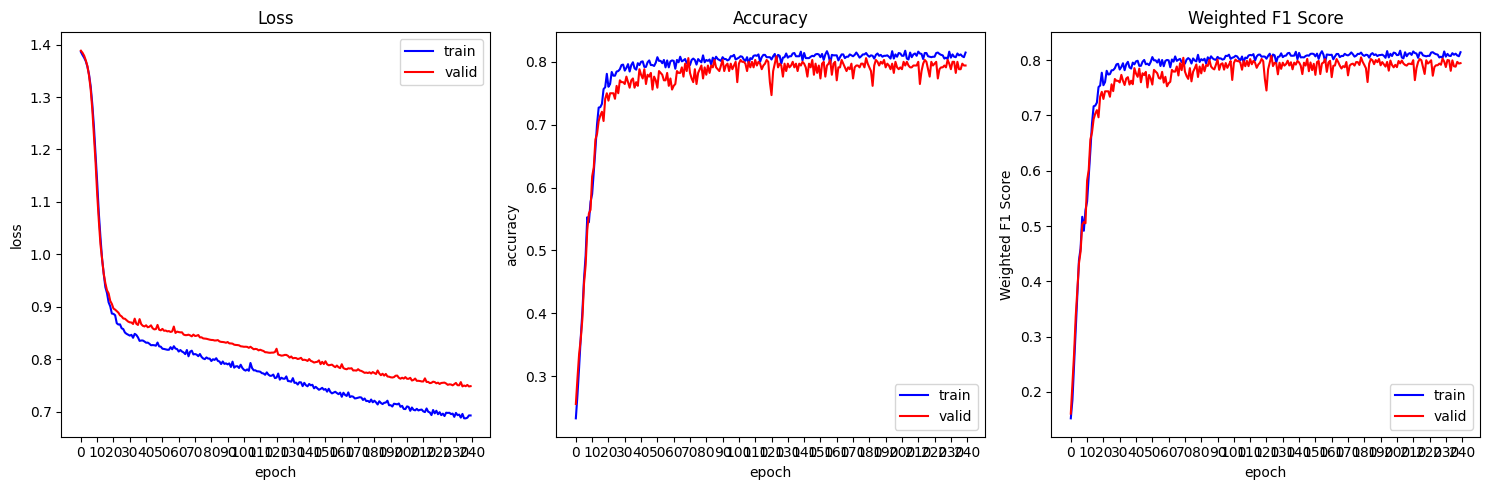

In [69]:
epoch_list = [e for e in range(NUM_EPOCHS)]
train_accuracy_list = [stat["accuracy"] for stat in train_statistics_list]
valid_accuracy_list = [stat["accuracy"] for stat in valid_statistics_list]
train_weighted_f1_score_list = [stat["weighted_f1_score"] for stat in train_statistics_list]
valid_weighted_f1_score_list = [stat["weighted_f1_score"] for stat in valid_statistics_list]


## print trend of statistics during the training process
xticks = [i * 10 for i in range(math.ceil(NUM_EPOCHS / 10) + 1)]
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# loss
axes[0].plot(epoch_list, train_loss_list, 'b', label='train')
axes[0].plot(epoch_list, valid_loss_list, 'r', label='valid')
axes[0].set_title("Loss")
axes[0].set_xlabel("epoch")
axes[0].set_ylabel("loss")
axes[0].set_xticks(xticks)
axes[0].legend()

# accuracy
axes[1].plot(epoch_list, train_accuracy_list, 'b', label='train')
axes[1].plot(epoch_list, valid_accuracy_list, 'r', label='valid')
axes[1].set_title("Accuracy")
axes[1].set_xlabel("epoch")
axes[1].set_ylabel("accuracy")
axes[1].set_xticks(xticks)
axes[1].legend()

# weighted f1 score
axes[2].plot(epoch_list, train_weighted_f1_score_list, 'b', label='train')
axes[2].plot(epoch_list, valid_weighted_f1_score_list, 'r', label='valid')
axes[2].set_title("Weighted F1 Score")
axes[2].set_xlabel("epoch")
axes[2].set_ylabel("Weighted F1 Score")
axes[2].set_xticks(xticks)
axes[2].legend()

plt.tight_layout()
plt.show()

In [70]:
# design your own algorithm to select the optimal model
## TODO: 
selected_model_epoch = int(np.argmax(valid_weighted_f1_score_list))  # the epoch index of your selected model

print("selected_model_epoch = {}".format(selected_model_epoch))

selected_model_epoch = 123


In [71]:
# load selected model
selected_model_save_name = "model_epoch_{:02d}.pt".format(selected_model_epoch)
selected_model_save_path = os.path.abspath(os.path.join(model_save_root, selected_model_save_name))
model.load_state_dict(torch.load(selected_model_save_path))
print("Selected Model: {}".format(selected_model_save_path))

Selected Model: C:\Users\User\Documents\114\ML\Lab4\model\model_epoch_123.pt


C:\Users\User\AppData\Local\Temp\ipykernel_30288\3747008627.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(selected_model_save_path))


In [72]:
## show statistics on training/validation dataset for the selected model
print("Statistics for the selected model: ")

# Model Peformance On Training Dataset
train_total_loss, train_statistics, train_y_pred = valid(train_dataloader)
print("Train -> Loss: {:.4f}, Accuracy: {:.4f}, F1 Score: {:.4f}".format(
    train_total_loss/len(train_dataloader), 
    train_statistics["accuracy"], 
    train_statistics["weighted_f1_score"], 
))

# Model Peformance On Valid Dataset
valid_total_loss, valid_statistics, valid_y_pred = valid(valid_dataloader)
print("Valid -> Loss: {:.4f}, Accuracy: {:.4f}, F1 Score: {:.4f}".format(
    valid_total_loss/len(valid_dataloader), 
    valid_statistics["accuracy"], 
    valid_statistics["weighted_f1_score"], 
))

Statistics for the selected model: 
Train -> Loss: 0.7584, Accuracy: 0.8118, F1 Score: 0.8110
Valid -> Loss: 0.8066, Accuracy: 0.8088, F1 Score: 0.8079


In [73]:
def test(
    dataloader     # the test dataloader
):
    y_pred = None  # collecting predictions for calculating statistics


    # set the model to eval mode
    model.eval()

    ## iterate each batch in test dataloader and evaluate the model
    with torch.no_grad():  # use `torch.no_grad` to ensure that no gradients are computed during evaluating model
        for idx, data in enumerate(dataloader):
            ## load data
            # load input features and label
            features = data["features"].to(DEVICE).float()

            
            ## evaluate model
            # forward propagation
            # Hint: pass the input features into model
            ## TODO: 
            output = model(features)


            ## collect statistics
            # collect output
            output = output.cpu().detach().numpy()

            # convert output to class index
            output = np.argmax(output, axis=1)

            # collect y_pred
            y_pred = np.concatenate((y_pred, output), axis=0) if(isinstance(y_pred, np.ndarray)) else output

    
    # return y_pred
    return y_pred

In [74]:
# get your test prediction
test_y_pred = test(test_dataloader)

In [75]:
# create a new dataframe containing your test prediction
df_test_pred = pd.DataFrame(test_y_pred)

In [76]:
# show your test prediction
display(df_test_pred.head(5))
print("Shape of test prediction: {}".format(df_test_pred.shape))  # Note: the shape of test prediction should be (300, 1)

,0
0,0
1,2
2,2
3,1
4,1


Shape of test prediction: (300, 1)


In [77]:
# save your test prediction as csv
df_test_pred.to_csv(test_prediction_csv_output_path, index=False)